In [28]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [29]:
# --------------------------------------------------
# DATA GENERATION CLASS: Noisy XOR
# --------------------------------------------------
class NoisyXORDataset(Dataset):
    """
    Generates samples from the noisy XOR distribution.

    Each sample is created as:
       (x1, x2) = (m1 + s * η1,  m2 + s * η2)
       y        = XOR(m1, m2)

    where (m1, m2) is one of four possible centers:
       (0,0), (0,1), (1,0), (1,1)

    η1, η2 are standard normal noise.
    """

    def __init__(self, n_samples=1000, noise_std=0.25):
        super().__init__()
        self.n_samples = n_samples
        self.noise_std = noise_std

        #Define 4 center points
        self.centers = np.array([[0,0], [0,1], [1,0], [1,1]], dtype=np.float32)
        #XOR labels for each center
        self.labels = np.array([0, 1, 1, 0], dtype=np.float32)

        #Generate all samples
        self.x, self.y = self._generate()

    def _generate(self):
        #Randomly choose one of the four centers for each sample
        idx = np.random.randint(0, 4, size=self.n_samples)
        base_points = self.centers[idx]

        #Add noise
        noise = np.random.randn(self.n_samples, 2).astype(np.float32) * self.noise_std

        x = base_points + noise
        y = self.labels[idx]  #XOR result for chosen center

        return x, y

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [30]:
# --------------------------------------------------
# FEEDFORWARD MODEL
# --------------------------------------------------
class FeedForwardNet(nn.Module):
    """
    Neural network matching the example in the assignment:

        Linear()
        Tanh
        Linear()
        Identity (output)

    The output will be used with BCEWithLogitsLoss,
    so it is returned as raw logits.
    """
    def __init__(self, num_hidden_layers, width):
        super().__init__()
        
        layers = []

        if num_hidden_layers > 0:
            layers.append(nn.Linear(2, width))
            layers.append(nn.Tanh())
        
        #hidden layers (width -> width)
            for _ in range(num_hidden_layers - 1):
                layers.append(nn.Linear(width, width))
                layers.append(nn.Tanh())
        
        #output layer (width -> 1)
            layers.append(nn.Linear(width, 1))
            
        else:
            #no hidden layers: 2 -> 1 directly, input -> output
            layers.append(nn.Linear(2, 1))

        layers.append(nn.Identity())

        self.model = nn.Sequential(*layers)
        

    def forward(self, x):
        return self.model(x).squeeze(1)



In [31]:
# --------------------------------------------------
# EVALUATION FUNCTION USED FOR EVALUATION LATER
# --------------------------------------------------
def evaluate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xbatch, ybatch in loader:
            xbatch = xbatch.float()
            ybatch = ybatch.float()
            logits = model(xbatch)
            loss = loss_fn(logits, ybatch)
            total_loss += loss.item() * len(xbatch)
    return total_loss / len(loader.dataset)


# --------------------------------------------------
# TRAINING LOOP
# --------------------------------------------------
def train(model, train_loader, val_loader, epochs=200, lr=1e-3): #train_loader consists of train x and train y and the same for val_loader
    """
    Standard mini‑batch training using Adam optimizer.
    """
    loss_fn = nn.BCEWithLogitsLoss()  #applies sigmoid internally
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_history = []
    val_history = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xbatch, ybatch in train_loader:
            xbatch = xbatch.float()
            ybatch = ybatch.float()

            optimizer.zero_grad()
            logits = model(xbatch)
            loss = loss_fn(logits, ybatch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(xbatch)

        avg_train_loss = total_loss / len(train_loader.dataset)

        #Evaluate on validation set
        val_loss = evaluate(model, val_loader, loss_fn)

        train_history.append(avg_train_loss)
        val_history.append(val_loss)

    return train_history, val_history

#Loop testing combinations of layers of hidden units and width
from torch.utils.data import DataLoader, TensorDataset

#Function to generate new datasets using the NoisyXOR and tensors
def generate_dataset(n_samples=200, noise_std=0.25):
    ds = NoisyXORDataset(n_samples=n_samples, noise_std=noise_std)
    x = torch.tensor(ds.x, dtype=torch.float32)
    y = torch.tensor(ds.y, dtype=torch.float32)
    return x, y

#Results storing
results = {}

#Loop over hidden layers og widths
for L in range(0, 4):          # 0,1,2,3 hidden layers
    for W in range(1, 4):      # widths 1,2,3
        
        val_losses = [] 

        for repeat in range(5):  #5 repetions for mean/std
            #Using function to generate new train dataset and val dataset
            train_x, train_y = generate_dataset(200)
            val_x, val_y     = generate_dataset(200)

            #Creating loaders for training and validation
            train_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=25, shuffle=True)
            val_loader   = DataLoader(TensorDataset(val_x, val_y), batch_size=25)

            #model using the model class
            model = FeedForwardNet(num_hidden_layers=L, width=W)

            #training the model
            train_hist, val_hist = train(model, train_loader, val_loader, epochs=200, lr=1e-3)

            #Saving the last validation loss
            val_losses.append(val_hist[-1])

        #Using numpy to calculate mean and std
        mean_val = float(np.mean(val_losses))
        std_val  = float(np.std(val_losses))

        results[(L, W)] = {"mean_val": mean_val, "std_val": std_val}

#results
for (L, W), stats in results.items():
    print(f"Hidden layers={L}, Width={W}: mean={stats['mean_val']:.4f}, std={stats['std_val']:.4f}")




Hidden layers=0, Width=1: mean=0.6947, std=0.0043
Hidden layers=0, Width=2: mean=0.7034, std=0.0035
Hidden layers=0, Width=3: mean=0.6972, std=0.0060
Hidden layers=1, Width=1: mean=0.6834, std=0.0121
Hidden layers=1, Width=2: mean=0.6336, std=0.0296
Hidden layers=1, Width=3: mean=0.6062, std=0.0292
Hidden layers=2, Width=1: mean=0.6123, std=0.0313
Hidden layers=2, Width=2: mean=0.5312, std=0.0666
Hidden layers=2, Width=3: mean=0.3765, std=0.1007
Hidden layers=3, Width=1: mean=0.6335, std=0.0337
Hidden layers=3, Width=2: mean=0.4977, std=0.1195
Hidden layers=3, Width=3: mean=0.3437, std=0.1205


In [32]:
# --------------------------------------------------
# VISUALIZATION
# --------------------------------------------------
def plot_points(dataset, title):
    """
    Scatter plot of noisy XOR data (blue = class 0, orange = class 1).
    """
    x, y = dataset.x, dataset.y

    plt.figure(figsize=(5,5))
    plt.scatter(x[y==0,0], x[y==0,1], label="Class 0", c="blue", edgecolor="k", alpha=0.6)
    plt.scatter(x[y==1,0], x[y==1,1], label="Class 1", c="orange", edgecolor="k", alpha=0.6)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.legend()
    plt.show()


def plot_decision_boundary(model, dataset, grid_res=200):
    """
    Draw the 50% probability contour (decision boundary) predicted by the model.
    """
    x, y = dataset.x, dataset.y

    #Create a grid of (x1, x2) points
    x_min, x_max = x[:,0].min() - 0.3, x[:,0].max() + 0.3
    y_min, y_max = x[:,1].min() - 0.3, x[:,1].max() + 0.3

    xx = np.linspace(x_min, x_max, grid_res)
    yy = np.linspace(y_min, y_max, grid_res)
    X1, X2 = np.meshgrid(xx, yy)
    grid = np.stack([X1.ravel(), X2.ravel()], axis=1).astype(np.float32)

    #Model predictions
    with torch.no_grad():
        logits = model(torch.from_numpy(grid))
        probs = torch.sigmoid(logits).numpy().reshape(X1.shape)

    #Plot contour where probability = 0.5
    plt.figure(figsize=(6,6))
    plt.contour(X1, X2, probs, levels=[0.5], linewidths=2, colors="k")

    #Plot data
    plt.scatter(x[y==0,0], x[y==0,1], c="blue", label="Class 0", edgecolor="k", alpha=0.6)
    plt.scatter(x[y==1,0], x[y==1,1], c="orange", label="Class 1", edgecolor="k", alpha=0.6)

    plt.title("Decision Boundary (p=0.5)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()


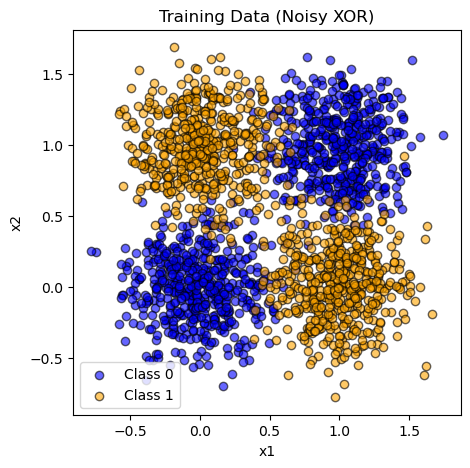

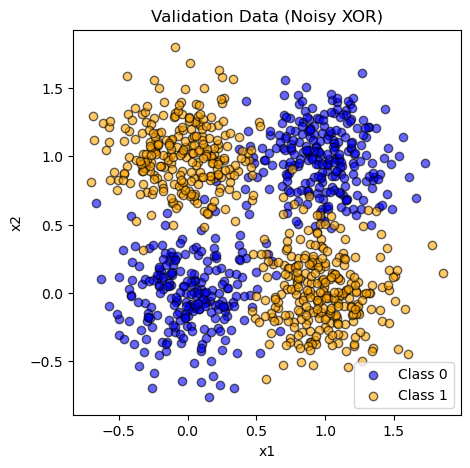

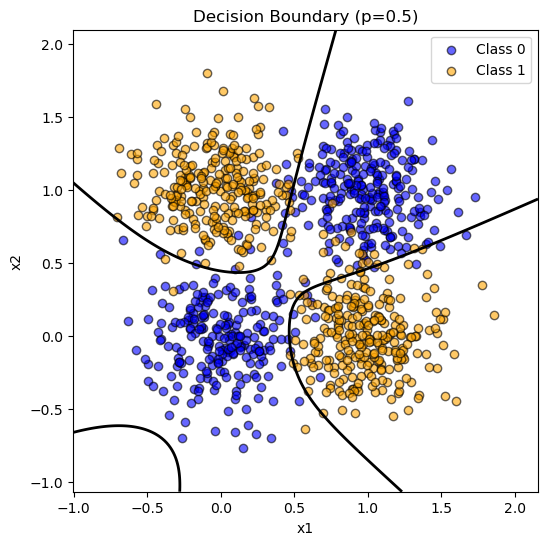

In [33]:

# --------------------------------------------------
# MAIN EXECUTION EXAMPLE WITH 2 HIDDEN LAYERS AND WIDTH 3
# --------------------------------------------------
if __name__ == "__main__":
    #Create training and validation datasets
    train_data = NoisyXORDataset(n_samples=2000, noise_std=0.25)
    val_data   = NoisyXORDataset(n_samples=1000, noise_std=0.25)

    #Visualize noisy XOR data
    plot_points(train_data, "Training Data (Noisy XOR)")
    plot_points(val_data, "Validation Data (Noisy XOR)")

    #Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_data, batch_size=64)

    #Initialize model
    model = FeedForwardNet(2,3)

    #Train
    train_hist, val_hist = train(model, train_loader, val_loader, epochs=200, lr=1e-3)

    #Plot decision boundary
    plot_decision_boundary(model, val_data)

## 4. 

In [34]:
import torch
import torch.nn as nn

class XORNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)   # 2 hidden units
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(2, 1)   # output unit

    def forward(self, x):
        h = self.tanh(self.fc1(x))
        out = self.fc2(h)
        return out, h


In [45]:
def train_with_snapshots(model, x_train, y_train, epochs=200, lr=1e-2, snapshot_every=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()
    snapshots = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        logits, _ = model(x_train)
        loss = loss_fn(logits.squeeze(1), y_train)
        loss.backward()
        optimizer.step()
        
        # Save snapshot of weights
        if epoch % snapshot_every == 0:
            snapshots.append({
                "fc1_weight": model.fc1.weight.detach().clone(),
                "fc1_bias": model.fc1.bias.detach().clone(),
                "fc2_weight": model.fc2.weight.detach().clone(),
                "fc2_bias": model.fc2.bias.detach().clone(),
            })
    return snapshots


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundaries(W1, b1, W2, b2, X, y, title=""):
    xx, yy = np.meshgrid(np.linspace(-0.25, 1.25, 200),
                         np.linspace(-0.25, 1.25, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Forward pass
    h = np.tanh(grid @ W1.T + b1)
    out = h @ W2.T + b2
    Z = (out > 0).astype(int).reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#ffcccc','#ccffcc']))
    plt.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['red','green']), s=100, edgecolor='k')
    plt.title(title)
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    plt.grid(True)
    plt.show()


In [47]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate_training(snapshots, X, y):
    fig, ax = plt.subplots(figsize=(5,5))

    xx, yy = np.meshgrid(np.linspace(-0.25, 1.25, 200),
                         np.linspace(-0.25, 1.25, 200))

    def update(frame):
        ax.clear()
        snap = snapshots[frame]
        W1 = snap["fc1_weight"].numpy()
        b1 = snap["fc1_bias"].numpy()
        W2 = snap["fc2_weight"].numpy()
        b2 = snap["fc2_bias"].numpy()

        h = np.tanh(np.c_[xx.ravel(), yy.ravel()] @ W1.T + b1)
        out = h @ W2.T + b2
        Z = (out > 0).astype(int).reshape(xx.shape)

        ax.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(['#ffcccc','#ccffcc']))
        ax.scatter(X[:,0], X[:,1], c=y, cmap=ListedColormap(['red','green']), s=100, edgecolor='k')
        ax.set_title(f"Epoch {frame*10}")
        ax.set_xlim(-0.25, 1.25)
        ax.set_ylim(-0.25, 1.25)
        ax.grid(True)

    ani = animation.FuncAnimation(fig, update, frames=len(snapshots), interval=300)
    plt.close(fig)
    return HTML(ani.to_jshtml())


In [48]:
# Data
X_data = np.array([[0,0],[0,1],[1,0],[1,1]])
y_data = np.array([0,1,1,0])
x_train = torch.tensor(X_data, dtype=torch.float32)
y_train = torch.tensor(y_data, dtype=torch.float32)

# Model
model = XORNet()

# Train & get snapshots
snapshots = train_with_snapshots(model, x_train, y_train, epochs=200, lr=0.1, snapshot_every=5)

# Animate
animate_training(snapshots, X_data, y_data)
